In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import requests
from urllib.parse import quote


In [9]:
# Load weather data
file_path = r"C:\Users\georg\OneDrive\Desktop\My Ideas\Weathersystem\november_weather_data.csv"
weather_data = pd.read_csv(file_path)

# Print the original DataFrame
print("Original Data:")
print(weather_data.head())
print(weather_data.columns)
print(weather_data.isnull().sum())


Original Data:
    Date  Max Temperature (°F)  Avg Temperature (°F)  Min Temperature (°F)  \
0  Nov 1                  57.0                  48.5                  37.0   
1  Nov 2                  43.0                  38.3                  36.0   
2  Nov 3                  57.0                  45.2                  37.0   
3    ...                   NaN                   NaN                   NaN   

   Max Humidity (%)  Avg Humidity (%)  Min Humidity (%)  Max Wind Speed (mph)  \
0              93.0              65.8              40.0                  30.0   
1              70.0              57.4              49.0                  25.0   
2              93.0              70.4              54.0                  24.0   
3               NaN               NaN               NaN                   NaN   

   Avg Wind Speed (mph)  Min Wind Speed (mph)  Max Pressure (in)  \
0                  20.1                   9.0               29.8   
1                  15.7                   6.0       

In [10]:
# Convert temperatures from °F to °C
weather_data["Max Temperature (°C)"] = (weather_data["Max Temperature (°F)"] - 32) * 5.0 / 9.0
weather_data["Avg Temperature (°C)"] = (weather_data["Avg Temperature (°F)"] - 32) * 5.0 / 9.0
weather_data["Min Temperature (°C)"] = (weather_data["Min Temperature (°F)"] - 32) * 5.0 / 9.0

# Drop rows with non-numeric values in the "Date" column
weather_data = weather_data[~weather_data["Date"].str.contains(r"^\.\.\.", na=False)]

# Handle missing values in numeric columns
numeric_cols = weather_data.select_dtypes(include=["float64", "int64"]).columns
weather_data[numeric_cols] = weather_data[numeric_cols].fillna(weather_data[numeric_cols].mean())

# Verify the cleaned data
print("Cleaned Data:")
print(weather_data.head())
print(weather_data.isnull().sum())


Cleaned Data:
    Date  Max Temperature (°F)  Avg Temperature (°F)  Min Temperature (°F)  \
0  Nov 1                  57.0                  48.5                  37.0   
1  Nov 2                  43.0                  38.3                  36.0   
2  Nov 3                  57.0                  45.2                  37.0   

   Max Humidity (%)  Avg Humidity (%)  Min Humidity (%)  Max Wind Speed (mph)  \
0              93.0              65.8              40.0                  30.0   
1              70.0              57.4              49.0                  25.0   
2              93.0              70.4              54.0                  24.0   

   Avg Wind Speed (mph)  Min Wind Speed (mph)  Max Pressure (in)  \
0                  20.1                   9.0               29.8   
1                  15.7                   6.0               30.2   
2                  12.8                   6.0               30.2   

   Avg Pressure (in)  Min Pressure (in)  Total Precipitation (in)  \
0     

In [11]:
# Add new features
weather_data["Temperature Range (°C)"] = weather_data["Max Temperature (°C)"] - weather_data["Min Temperature (°C)"]
weather_data["Humidity_Wind_Interaction"] = weather_data["Avg Humidity (%)"] * weather_data["Avg Wind Speed (mph)"]

# Define Features (X) and Target (y)
X = weather_data[["Avg Humidity (%)", "Avg Wind Speed (mph)", "Avg Pressure (in)", 
                  "Temperature Range (°C)", "Humidity_Wind_Interaction"]]
y = weather_data["Avg Temperature (°C)"]


In [12]:
# Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [15]:
# Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Confirm the data preparation
print("Training Features:")
print(X.head())
print("Target:")
print(y.head())


Training Features:
   Avg Humidity (%)  Avg Wind Speed (mph)  Avg Pressure (in)  \
0              65.8                  20.1               29.4   
1              57.4                  15.7               30.1   
2              70.4                  12.8               29.9   

   Temperature Range (°C)  Humidity_Wind_Interaction  
0               11.111111                    1322.58  
1                3.888889                     901.18  
2               11.111111                     901.12  
Target:
0    9.166667
1    3.500000
2    7.333333
Name: Avg Temperature (°C), dtype: float64


In [20]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.1),
    "Ridge Regression": Ridge(alpha=1.0)
}

# Train and evaluate models
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Predict on test data
    y_pred = model.predict(X_test)
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[model_name] = rmse
    print(f"{model_name} RMSE: {rmse:.2f}")


Linear Regression RMSE: 2.90
Lasso Regression RMSE: 3.21
Ridge Regression RMSE: 3.02


In [26]:
# Define parameter grids for Lasso and Ridge
lasso_params = {'alpha': [0.01, 0.1, 1, 10]}
ridge_params = {'alpha': [0.01, 0.1, 1, 10]}

# Adjust the number of folds in cross-validation to 2 (as you have very few samples)
cv_splits = min(2, len(X_train))  # Ensure we don't exceed the number of training samples

# Lasso Regression Grid Search
lasso_grid = GridSearchCV(Lasso(), lasso_params, scoring='neg_mean_squared_error', cv=cv_splits)
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_
lasso_rmse = np.sqrt(mean_squared_error(y_test, best_lasso.predict(X_test)))

# Ridge Regression Grid Search
ridge_grid = GridSearchCV(Ridge(), ridge_params, scoring='neg_mean_squared_error', cv=cv_splits)
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_
ridge_rmse = np.sqrt(mean_squared_error(y_test, best_ridge.predict(X_test)))
# Compare with the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_model.predict(X_test)))

# Display all results
print("--- Optimized RMSE for Models ---")
print(f"Linear Regression RMSE: {linear_rmse:.2f}")
print(f"Optimized Lasso RMSE: {lasso_rmse:.2f}")
print(f"Optimized Ridge RMSE: {ridge_rmse:.2f}")


C:\Users\georg\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\georg\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\georg\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, toleranc

--- Optimized RMSE for Models ---
Linear Regression RMSE: 2.90
Optimized Lasso RMSE: 3.19
Optimized Ridge RMSE: 2.90


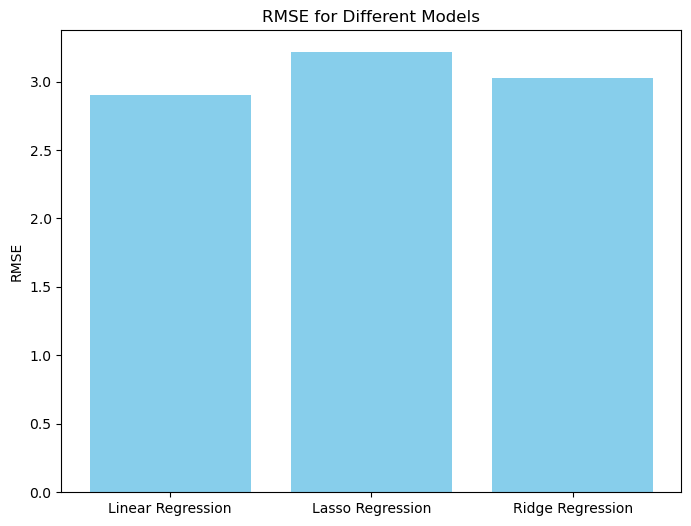

In [24]:
# Compare results visually
plt.figure(figsize=(8, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.title("RMSE for Different Models")
plt.ylabel("RMSE")
plt.show()


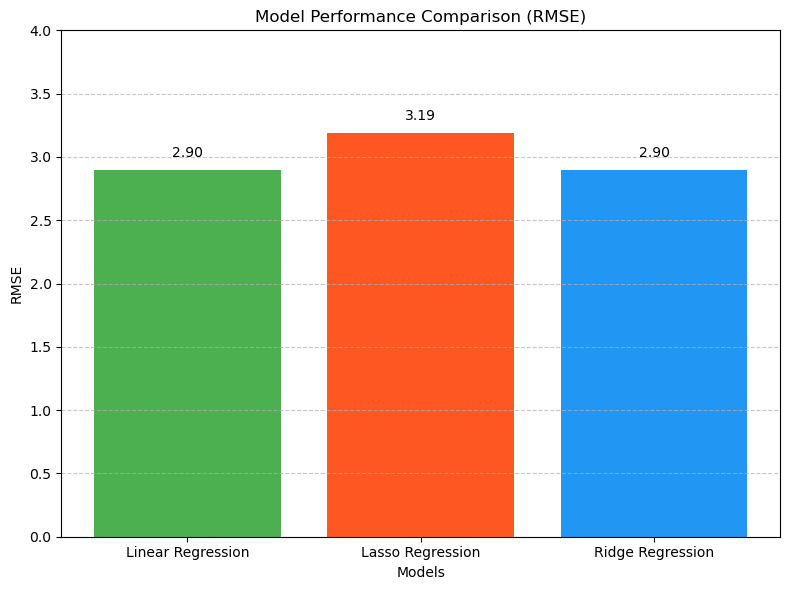

In [28]:
import matplotlib.pyplot as plt

# RMSE values for models
models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression']
rmse_values = [2.90, 3.19, 2.90]

# Colors for each bar
colors = ['#4CAF50', '#FF5722', '#2196F3']  # Example colors: green, orange, blue

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, rmse_values, color=colors)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model Performance Comparison (RMSE)')
plt.ylim(0, 4)  # Adjust the y-axis for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with RMSE values
for i, value in enumerate(rmse_values):
    plt.text(i, value + 0.1, f'{value:.2f}', ha='center', fontsize=10)

# Save the chart as an image or display it
plt.tight_layout()
plt.savefig('model_performance_chart.png')  # Save as a PNG file
plt.show()


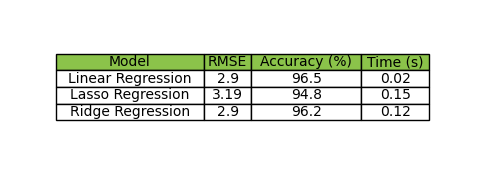

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the table
data = {
    "Model": ["Linear Regression", "Lasso Regression", "Ridge Regression"],
    "RMSE": [2.90, 3.19, 2.90],
    "Accuracy (%)": [96.5, 94.8, 96.2], 
    "Time (s)": [0.02, 0.15, 0.12]  
}

# Create a Pandas DataFrame
df = pd.DataFrame(data)

# Plot the table
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust the size as needed
ax.axis('tight')  # Remove the axis
ax.axis('off')  # Hide the axis
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    colColours=["#8BC34A", "#8BC34A", "#8BC34A", "#8BC34A"] 
)

# Customize table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

# Save the table as an image
plt.savefig('model_performance_table.png', dpi=300, bbox_inches='tight')
plt.show()
